In [3]:
%matplotlib notebook

import random

import numpy as np

from environment import Easy21Environment, Easy21State

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Monte-Carlo Agent

In [4]:
class MonteCarloAgent():
    def __init__( self ):
        # Params
        self.n_0 = 100000
        self.total_episodes = 2 ** 16

        # Globals
        self.env = Easy21Environment()

        # Vars
        self.visits = self.emptyStateActionSpace()
        self.q_estimate = self.emptyStateActionSpace()
        self.actions = self.env.getActionSpace()
        
    def combineStateAction( self, state, action ):
        return tuple( list( state ) + [ action ] )
        
    def emptyStateActionSpace( self ):
        state_action_space = self.combineStateAction( self.env.getStateSpace(), self.env.getActionSpace() )
        return np.zeros( state_action_space )
        
    def getStateVisits( self, state ):
        """
        Sum over actions for state
        """
        return np.sum( self.visits[ tuple( state ) ] )

    def getEpsilon( self, state ):
        state_visits = self.getStateVisits( state )
        return self.n_0 / ( self.n_0 + state_visits )

    def epsilonGreedy( self, state ):
        """
        Uses epsilon greedy policy to select an action
        epsilon = n_0 / ( n_0 + N( s ) )
        if random > epsilon:
            act greedy (select action with highest estimated reward)
        else:
            act random
        """
        epsilon = self.getEpsilon( state )
        if( random.random() > epsilon ): # Act greedy 
            return self.q_estimate[ tuple( state ) ].argmax()
        else:
            return random.randint( 0, self.actions-1 )

    def getAction( self, state ):
        return self.epsilonGreedy( state )
        
    def getStep( self, state ):
        return 1 / self.visits[ tuple( state ) ]

    def train( self ):
        training_total_wins = 0
        for i in range( self.total_episodes ):
            # Run Episode
            state = Easy21State()
            used_state_actions = []
            total_reward = 0
            while not state.terminal:
                action = self.getAction( state.state() )
                used_state_actions.append( np.append( state.state(), action ) )
                state, reward = self.env.step( state, action )
                total_reward += reward

            if total_reward == 1:
                training_total_wins += 1

            # Learn
            for used_state_action in used_state_actions:
                self.visits[ tuple( used_state_action ) ] += 1
                estimate = self.q_estimate[ tuple( used_state_action ) ]
                error = total_reward - estimate
                step = self.getStep( used_state_action )
                """
                step_size = 1 / N( s, a )
                """
                new_estimate = estimate + error * step
                self.q_estimate[ tuple( used_state_action ) ] = new_estimate
                """
                Q(s,a) = Q(s, a) + ( ( step_size ) * ( actual_reward - Q( s, a ) ) )
                """

        return training_total_wins / self.total_episodes

In [8]:
mca = MonteCarloAgent()

mca.n_0 = 100
mca.total_episodes = 10000

for i in range( 100 ):
    mca.train()

<IPython.core.display.Javascript object>


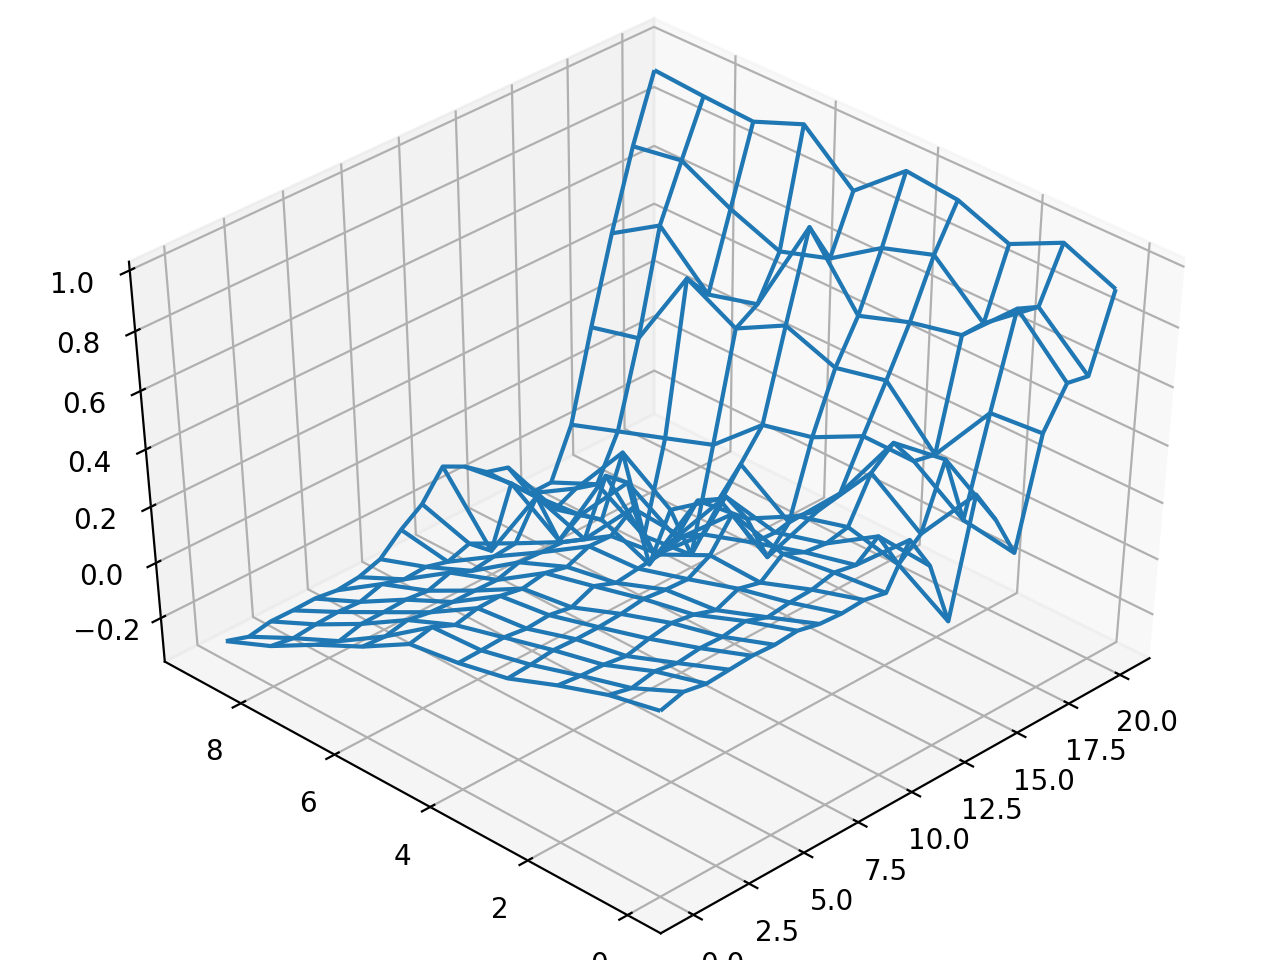

<IPython.core.display.Javascript object>


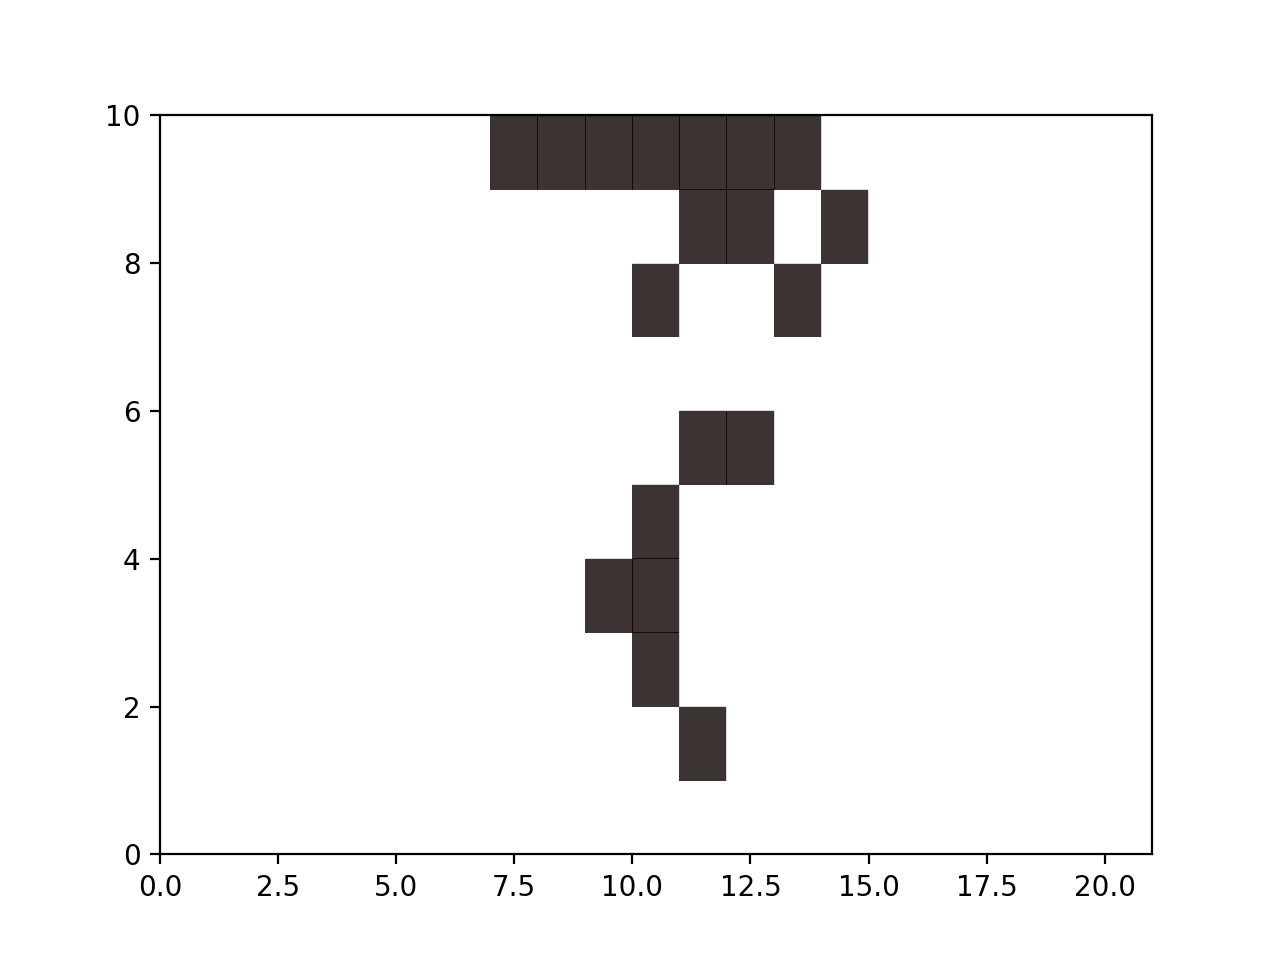

<IPython.core.display.Javascript object>


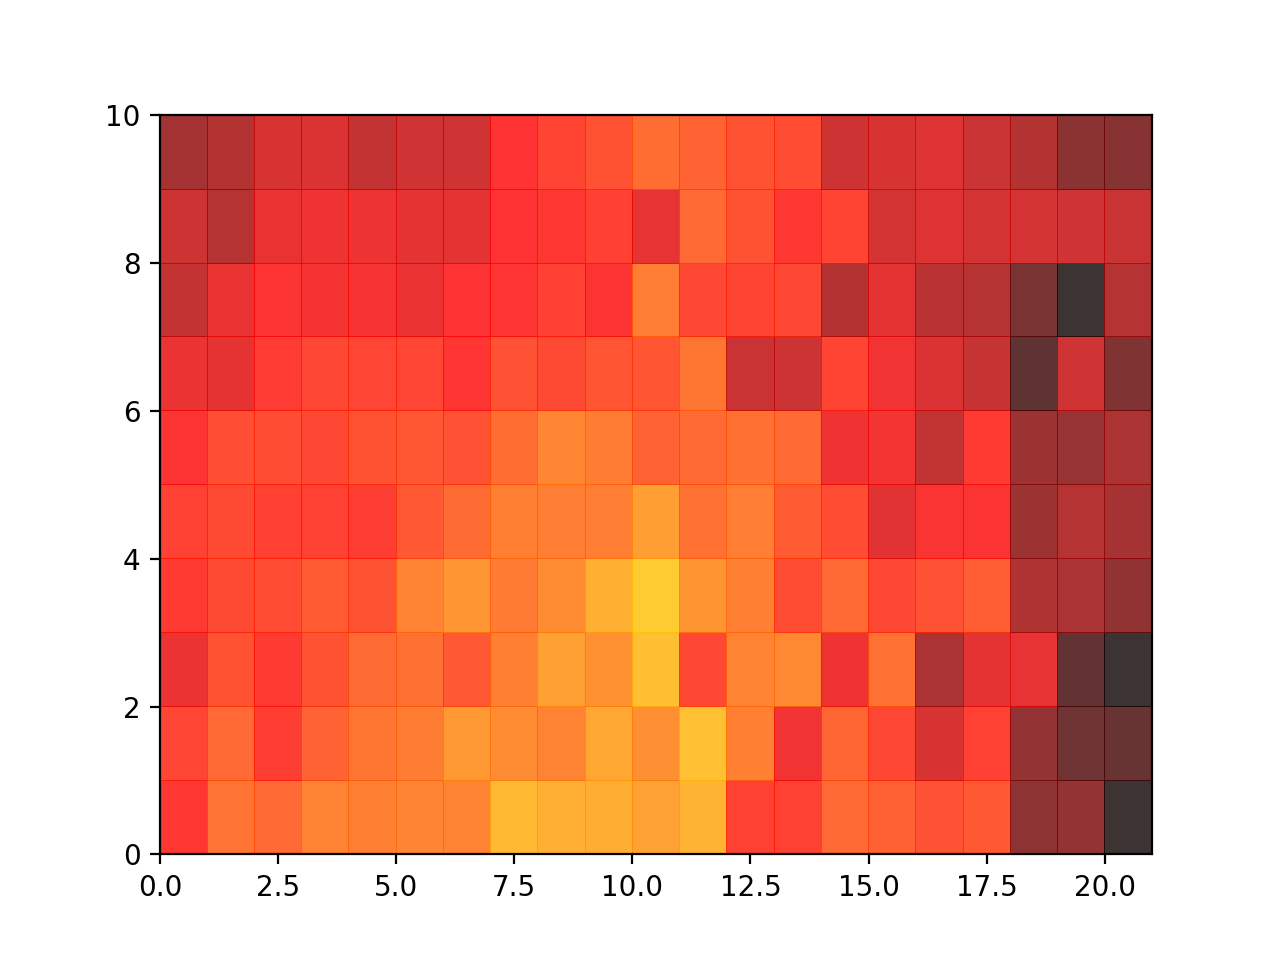

<IPython.core.display.Javascript object>


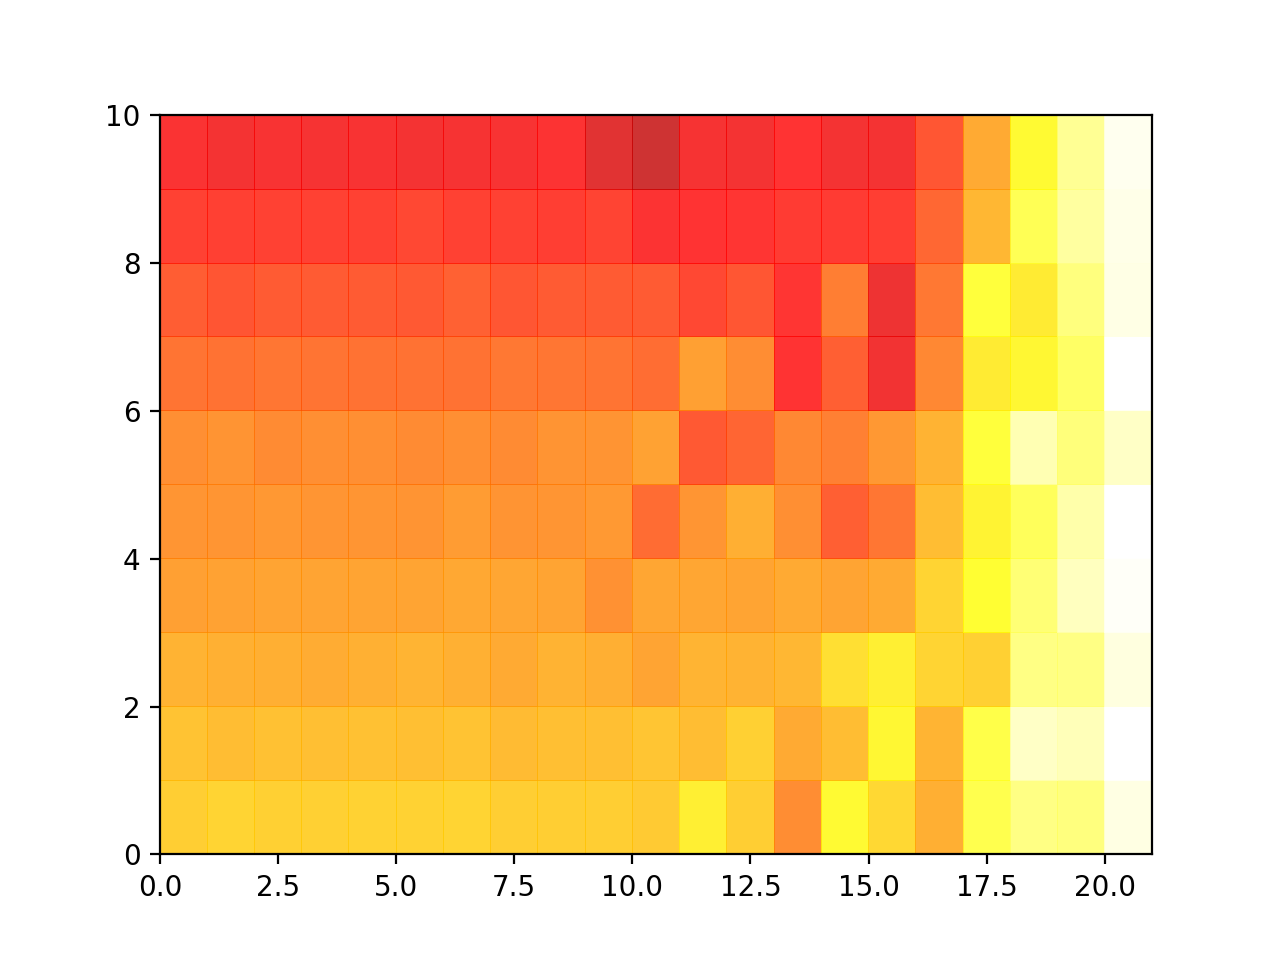

In [91]:
def plot( z ):
    x = range( z.shape[ 1 ] )
    y = range( z.shape[ 0 ] )
    X, Y = np.meshgrid( x, y )
    
    fig = plt.figure()
    ax = Axes3D( fig )
    ax.plot_wireframe( X, Y, z )

plot( np.max( mca.q_estimate, axis=2 ) )

fig, ax = plt.subplots()
ax.pcolor(np.argmax( mca.q_estimate, axis=2 ), cmap=plt.cm.hot, alpha=0.8)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 0], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 1], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)

## Sansa(Lambda)



In [271]:
class SansaLambdaAgent(MonteCarloAgent):
    """
    Agent for Sansa(Lambda)
    We are using the same exploration schedule / step size
    so we just inherit those methods from MonteCarlo
    """
    def __init__( self ):
        super().__init__()
        self.train_lambda = 0.1

    def update( self, reward, state_action, next_state_action=None ):
        self.visits[ state_action ] += 1
        self.eligability_traces[ state_action ] += 1

        estimated_future_reward = 0
        if next_state_action is not None:
            estimated_future_reward = self.q_estimate[ next_state_action ]

        estimated_reward = self.q_estimate[ state_action ]
        error = reward + estimated_future_reward - estimated_reward

        for position, eligibility in np.ndenumerate( self.eligability_traces ):
            if eligibility == 0.0:
                continue
            step = self.getStep( position )
            self.q_estimate[ position ] += eligibility * step * error
            self.eligability_traces[ position ] *= self.train_lambda

    def episode_reset( self ):
        self.eligability_traces = self.emptyStateActionSpace()

    def train( self ):
        train_total_reward = 0
        for i in range( self.total_episodes ):
            self.episode_reset()

            state = Easy21State()
            last_action = self.getAction( state.state() )
            while not state.terminal:
                next_state, reward = self.env.step( state, last_action )
                train_total_reward += reward

                state_action = self.combineStateAction( state.state(), last_action )
                next_action = None
                next_state_action = None

                # There is no future reward if the next_state is terminal
                if not next_state.terminal:
                    next_action = self.getAction( next_state.state() )
                    next_state_action = self.combineStateAction( next_state.state(), next_action )
    
                self.update( reward, state_action, next_state_action )
    
                state = next_state
                last_action = next_action
        return train_total_reward / self.total_episodes

In [25]:
def trainForLambda( train_lambda ):
    sla = SansaLambdaAgent()
    sla.total_episodes = 1000
    sla.train_lambda = train_lambda
    sla.train()

    mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
    print( train_lambda, mean_squared_error )

for i in np.linspace( 0, 1, 11 ):
    trainForLambda( i )

0.0 105.60035765849963
0.1 98.14017091030728
0.2 105.70941185097078
0.30000000000000004 100.84616079224983
0.4 97.4342783696691
0.5 101.31337131907117
0.6000000000000001 103.72819633013887
0.7000000000000001 116.68578571688484
0.8 121.88517212119442
0.9 117.09915657092027
1.0 140.0903830487852


<IPython.core.display.Javascript object>


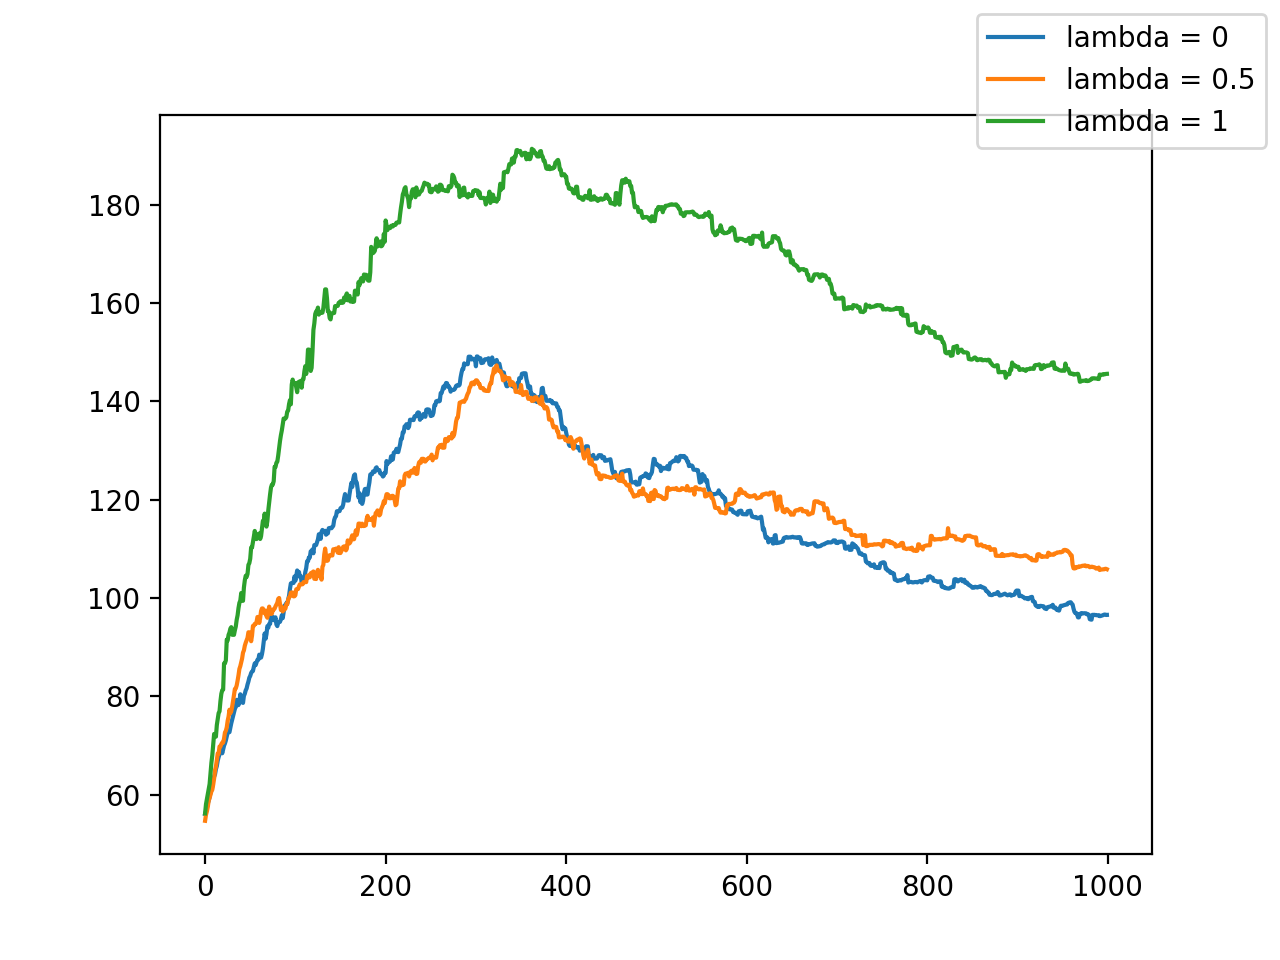

In [26]:
fig = plt.figure()

for train_lambda in [ 0, 0.5, 1 ]:
    sla = SansaLambdaAgent()
    sla.total_episodes = 1
    sla.train_lambda = train_lambda
    mean_squared_errors = []
    for i in range( 1000 ):
        sla.train()
        mean_squared_error = np.sum( ( sla.q_estimate - mca.q_estimate ) ** 2 )
        mean_squared_errors.append( mean_squared_error )
    plt.plot( mean_squared_errors, label="lambda = " + str( train_lambda ) )

fig.legend()

In [289]:
class LinearFunctionApproxAgent(SansaLambdaAgent):
    """
    Agent for Cuboids Linear Function Approx
    """
    def __init__( self ):
        self.total_episodes = 2 ** 16

        # Globals
        self.env = Easy21Environment()

        # TODO: This cuboid policy could be done more generically
        self.cuboids = np.array( [
            [ [ 1, 4 ], [ 4, 7 ], [ 7, 10 ] ],
            [ [ 1, 6 ], [ 4, 9 ], [ 7, 12 ], [ 10, 15 ], [ 13, 18 ], [ 16, 21 ] ]
        ] )

        self.binary_feature_count = len( self.cuboids[ 0 ] ) + len( self.cuboids[ 1 ] )
        self.weights = np.zeros( ( self.binary_feature_count, 2 ) )
        
        self.epsilon = 0.05
        self.step_size = 0.01
        self.train_lambda = 0.5
        self.actions = 2

    def getBinaryFeatures( self, state ):
        dealer_start, player_sum = ( np.array( state ) + 1 )
        # One binary feature for each dealer state, and for each player state
        dealer_features = len( self.cuboids[ 0 ] )
        binary_features = np.zeros( ( self.binary_feature_count ) )

        for position, crange in enumerate( self.cuboids[ 0 ] ):
            if dealer_start >= crange[ 0 ] and dealer_start <= crange[ 1 ]:
                binary_features[ position ] = 1

        for position, crange in enumerate( self.cuboids[ 1 ] ):
            if player_sum >= crange[ 0 ] and player_sum <= crange[ 1 ]:
                binary_features[ dealer_features +  position ] = 1

        return binary_features

    def getFeatureActions( self, state ):
        """
        Takes state, finds binary features size (feature_count,1) then turns into
        size (feature_count, action_count) so we can multiply by our weights
        """
        binary_features = self.getBinaryFeatures( state )

        binary_features_doubled = np.zeros( ( 9, 2 ) )
        binary_features_doubled[ :, 0 ] = binary_features
        binary_features_doubled[ :, 1 ] = binary_features
        
        return binary_features_doubled
    
    def q( self, state_action ):
        """
        Return the weight sum for the selected state_action
        """
        if state_action is None:
            return 0

        # State -> Features: Get the features, and multiply by the weights
        feature_actions = self.getFeatureActions( state_action[ :2 ] )
        weighted_features = self.weights * feature_actions
        # Only sum weights for the selected action
        return np.sum( weighted_features[ :, state_action[ -1 ] ] )

    def getAction( self, state ):
        if( random.random() < self.epsilon ):
            return random.randint( 0, self.actions - 1 )
            
        feature_actions = self.getFeatureActions( state )
        
        weighted_features = feature_actions * self.weights
        weighted_actions = np.sum( weighted_features, axis=0 )

        return weighted_actions.argmax()

    def episode_reset( self ):
        self.eligability = np.zeros( ( self.binary_feature_count, 2 ) )

    def update( self, reward, state_action, next_state_action ):
        estimated_next_reward = 0
        error = ( reward + self.q( next_state_action ) ) - self.q( state_action )

        binary_features = self.getBinaryFeatures( state_action[ 0:2 ] )
        eligability_update = np.zeros( list( binary_features.shape ) + [ self.actions ] )
        eligability_update[ :, state_action[-1] ] = binary_features
        self.eligability = ( self.eligability * self.train_lambda ) + eligability_update

        self.weights += self.step_size * self.eligability * error

lfaa = LinearFunctionApproxAgent()
lfaa.total_episodes = 1000
lfaa.train()
lfaa.total_episodes = 1000
lfaa.train()

0.072

<IPython.core.display.Javascript object>


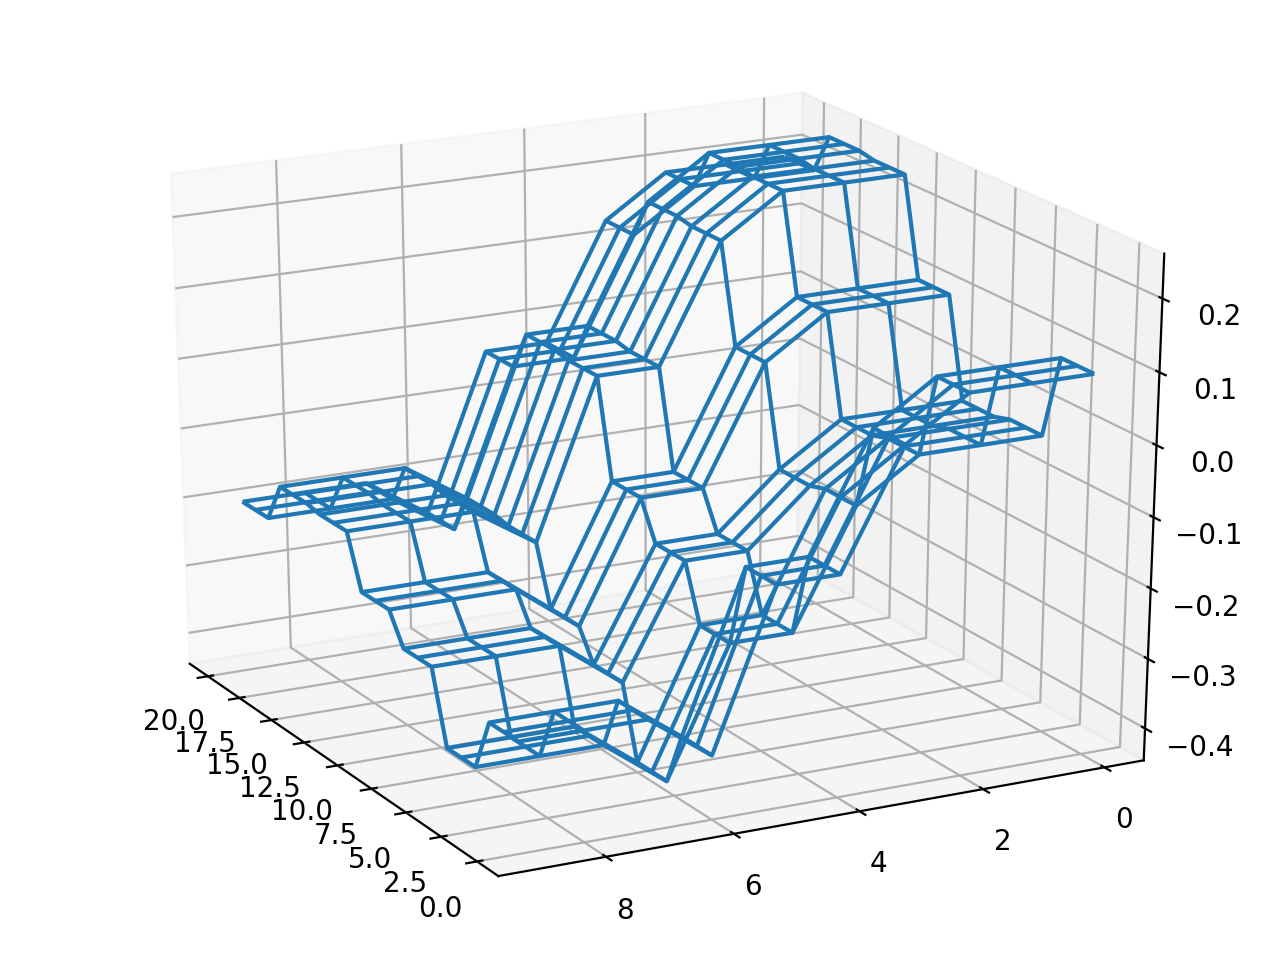

In [270]:
def plotValueFunction( lfaa, mca ):
    """
    Uses the equivalant mca for reference
    """
    lfaa_complete_q_estimate = np.zeros( mca.q_estimate.shape )
    for state_action, _ in np.ndenumerate( mca.q_estimate ):
        lfaa_complete_q_estimate[ state_action ] = lfaa.q( state_action )
    plot( np.max( lfaa_complete_q_estimate, axis=2 ) )

plotValueFunction( lfaa, mca )

In [294]:
def getMeanSquaredError( lfaa, mca ):
    mean_squared_error = 0
    for state_action, q_estimate in np.ndenumerate( mca.q_estimate ):
        mean_squared_error += ( lfaa.q( state_action ) - q_estimate ) ** 2
    return mean_squared_error

def trainLfaaForLambda( train_lambda ):
    lfaa = LinearFunctionApproxAgent()
    lfaa.total_episodes = 1000
    lfaa.train_lambda = train_lambda
    lfaa.train()

    mean_squared_error = getMeanSquaredError( lfaa, mca )
    print( train_lambda, mean_squared_error )

for i in np.linspace( 0, 1, 11 ):
    trainLfaaForLambda( i )

0.0 36.94498688625421
0.1 30.801516058322843
0.2 46.84512994993218
0.30000000000000004 40.115614873125665
0.4 30.024232637060738
0.5 37.64553801091463
0.6000000000000001 32.09099828658539
0.7000000000000001 39.19992436639811
0.8 33.23548708042762
0.9 36.051832636780844
1.0 38.028800700747944


<IPython.core.display.Javascript object>


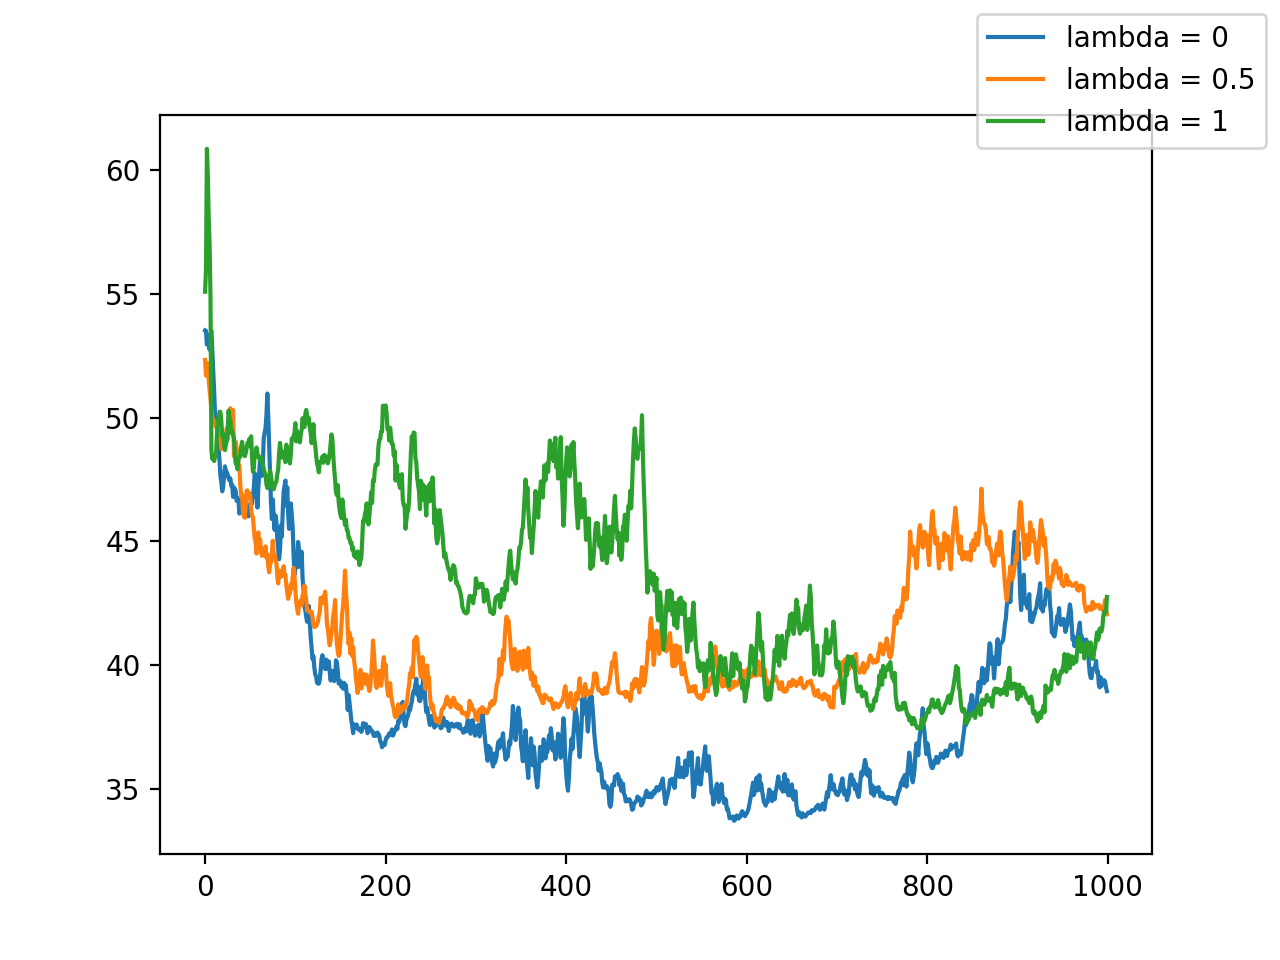

In [295]:
fig = plt.figure()

for train_lambda in [ 0, 0.5, 1 ]:
    lfaa = LinearFunctionApproxAgent()
    lfaa.total_episodes = 1
    lfaa.train_lambda = train_lambda
    mean_squared_errors = []
    for i in range( 1000 ):
        lfaa.train()
        mean_squared_errors.append( getMeanSquaredError( lfaa, mca ) )
    plt.plot( mean_squared_errors, label="lambda = " + str( train_lambda ) )

fig.legend()